In [63]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
from scipy import stats # Статистика
from db_utils import get_connection

%matplotlib inline

In [64]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [65]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (2000, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (2000, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [66]:
connection = get_connection()

In [67]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-10-03' and '2022-10-09'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [68]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

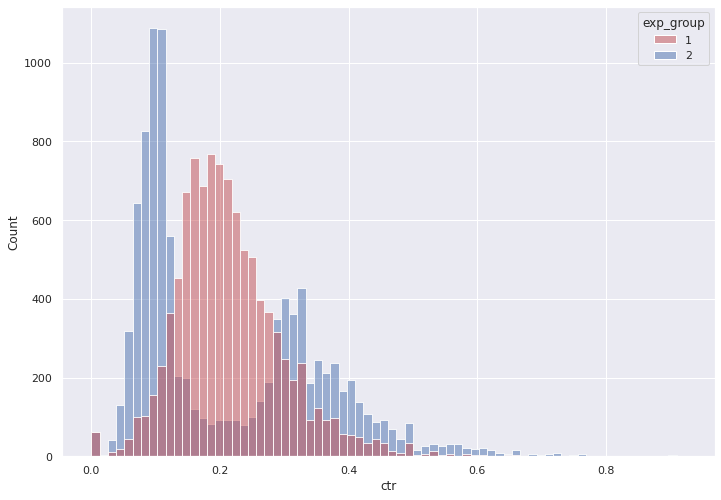

In [69]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

# T-test

In [70]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

Значительные отличия в форме распределения приводят к тому, что тест может быть ненадежен, его результатам не стоит доверять

# Mann-Whitney U-test

In [71]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Тест Манна-Уитни говорит, что есть статистически значимые различия между группами

# Smoothed CTR

In [72]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [73]:
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

In [74]:
bins = np.linspace(df.ctr.min(), df.ctr.max(), 100)

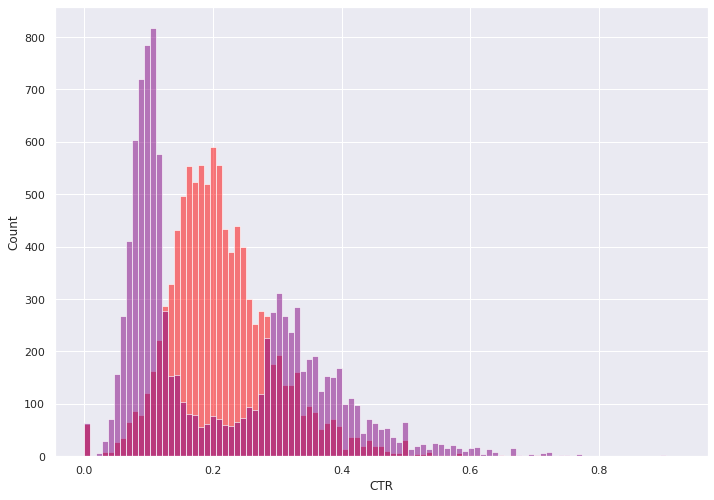

In [75]:
#Построим гистограмму CTR
sns.histplot(group1.ctr,
             color = 'red',
             alpha=0.5,
             bins = bins,
             kde = False)
sns.histplot(group2.ctr,
             color = 'purple',
             alpha=0.5,
             bins = bins,
             kde = False)
_ = plt.xlabel('CTR')

In [76]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

In [77]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)


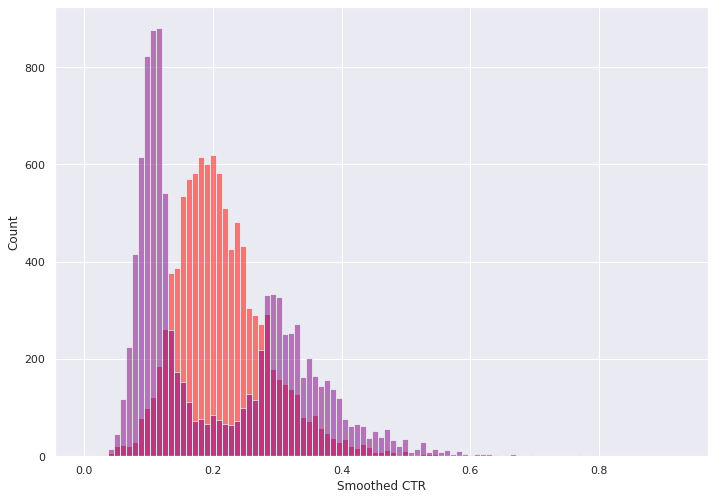

In [78]:
#Построим гистограмму для сглаженного CTR
sns.histplot(group1.smothed_ctr, 
             color = 'red',
             alpha=0.5,
             bins = bins,
             kde = False)
sns.histplot(group2.smothed_ctr,
             color = 'purple',
             alpha=0.5,
             bins = bins,
             kde = False)
_ = plt.xlabel('Smoothed CTR')

Сравнивая графики, видим, что стало меньше выбросов, графики 'сгладились'.

In [79]:
#проведем t-test по сглаженному CTR
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

В результате получили значение p-value меньше 0.05, но как и в первом случае, по гистограме мы видим, что вид распределения далек от нормального. Результатам такого теста доверять не стоит. 

In [80]:
#проведем mannwhitney test по сглаженному CTR
stats.mannwhitneyu(group1.smothed_ctr,
                   group2.smothed_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

Как и в первом случае, тест Манна-Уитни показывает, что есть отличие между группами

# Poisson bootstrap

In [81]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [82]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

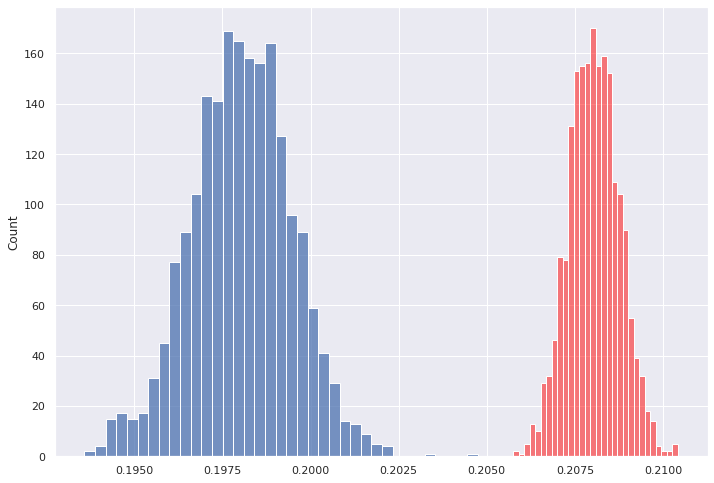

In [83]:
sns.histplot(ctr1, color = 'red', alpha = 0.5)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

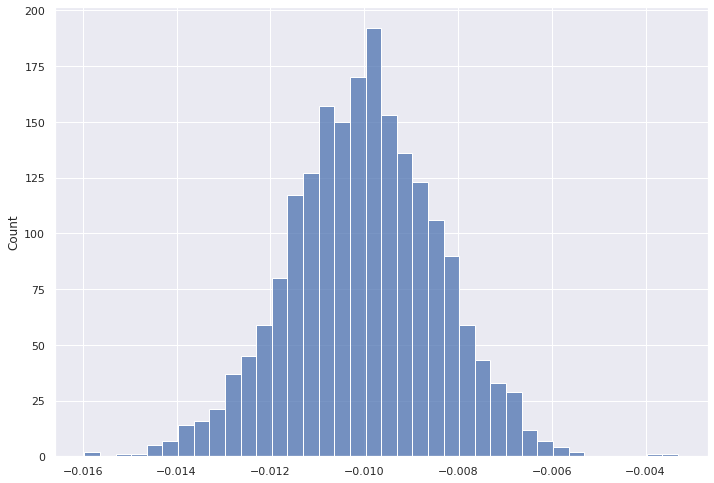

In [84]:
sns.histplot(ctr2 - ctr1)

По гистограмме разницы между глобальными CTR двух групп, мы видим, что эта разница отрицательна и не пересекает 0, а значит, CTR контрольной группы больше CTR группы, на которой проводился эксперимент.

# Bucket transform

In [85]:
q2 = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-10-03' and '2022-10-09'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_b = pandahouse.read_clickhouse(q2, connection=connection)

In [86]:
stats.mannwhitneyu(df_b[df_b.exp_group == 1].bucket_ctr, 
                   df_b[df_b.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Тест Манна-Уитни видит различие между группами.

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

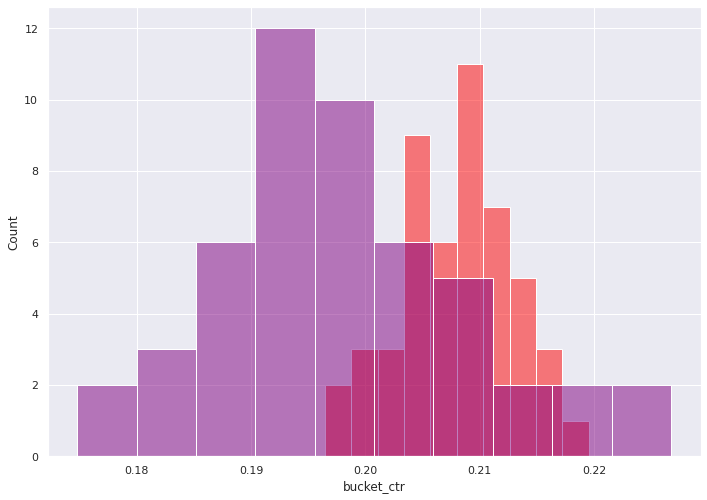

In [87]:
sns.histplot(df_b[df_b.exp_group == 1].bucket_ctr, 
             color = 'red',
             alpha=0.5,
             bins = 10,
             kde = False)
sns.histplot(df_b[df_b.exp_group == 2].bucket_ctr,
            color = 'purple',
             alpha=0.5,
             bins = 10,
             kde = False)

In [88]:
stats.ttest_ind(df_b[df_b.exp_group == 1].bucket_ctr, 
                   df_b[df_b.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

Т.к. распределение отдаленно напоминает нормальное, провели T-тест, его результат говорит о статически значимом различии между группами.

### Выводы
В результате проведенных тестов мы видим, что между группами есть статистически значимые различия. Однако, как показывает результат анализа Пуассоновского бустрепа, значение глобального CTR в контрольной группе оказалось выше, чем в экспериментальной. 

Сравнивая гистограммы распределения CTR для обеих групп мы также видим, что после проведения эксперимента для значимой части пользователей CTR стал меньше, т.е. на них не сработала новая модель выдачи постов, предыдущая модель работала лучше.

Можно предположить, что обучающая выборка в новой модели не учла какую-то группу людей. Можно проанализировать более  детально, для пользователей с какими признаками CTR стал меньше, и учесть эту информацию при дальнейшей работе над моделью.

По моему мнению,  раскатывать новый алгоритм на всех новых пользователей пока не стоит, алгоритм требует доработки. 